train.csv, test.csv
- game_id : Unique id for the game
- nickname : Player's username on woogles.io
- score : Final score for each player for each game.
- rating : Player's rating on woogles.io BEFORE the game was played; ratings are per Lexicon / time control name (AKA game variant). In test.csv, ratings are NA for player games; this is what you are predicting.

games.csv
- game_id : Unique id for the game
- first : Which player went first
- time_control_name : Name of time control used ("regular", "rapid", or "blitz")
- game_end_reason : How the game ended
- winner : Who won the game
- created_at : When the game was created
- lexicon : English lexicon used in the game ("CSW19", "NWL20", "CSW21")
- initial_time_seconds : Time limit each player has in the game (defines the time control name)
- increment_seconds : Time increment each player gets each time they play a turn
- rating_mode : Whether the game counts towards player ratings or not ("RATED", "CASUAL")
- max_overtime_minutes : How far past the initial time limit players can go before they timeout
- game_duration_seconds : How long the game lasted

turns.csv
- turns.csv contains full data for every turn for each game.
- game_id : Unique id for the game
- turn_number : The turn number in the game
- nickname : Player's username on woogles.io
- rack : Player's current rack
- location : Where the player places their turn on the board (NA for games in the test set or if the player didn't make a play, e.g., if they exchanged)
- move : Tiles the player laid (NA for games in the test set; "--" if the turn_type was "Pass"; "(challenge)" if the turn_type was "Challenge"; "-" plus tiles exchanged if the turn_type was "Exchange"; at the end of the game, remaining tiles in a player's rack are in parentheses)
- points : Points the player earned (or lost) in their turn
- score : Player's total score at the time of the turn
- turn_type : Type of turn played ("Play", "Exchange", "Pass", "Six-Zero Rule" (i.e., a game that ends when players pass 3 turns in a row each), "Challenge")

## 시작

In [146]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

- train.csv

In [147]:
train = pd.read_csv('train.csv')
print('len(train):',len(train))
train.head()

len(train): 100820


,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


- test.csv

In [148]:
test = pd.read_csv('test.csv')
print('len(test):',len(test))
test.head()

len(test): 44726


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


- games.csv

In [149]:
games = pd.read_csv('games.csv')
print('len(games):',len(games))
games.head()

len(games): 72773


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


- turns.csv

In [150]:
turns = pd.read_csv('turns.csv')
print('len(turns):',len(turns))
turns.head()

len(turns): 2005498


,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


- create variables

In [151]:
games['created_at_yyyy'] = games.created_at.str[0:4]
games['created_at_mm'] = games.created_at.str[5:7]
games['created_at_hh'] = games.created_at.str[11:13]
games['created_at_weekday'] = pd.to_datetime(games.created_at).dt.weekday
games['created_at_weekday_gubun'] = 0
games.loc[games.created_at_weekday == 5,'created_at_weekday_gubun'] = 1
games.loc[games.created_at_weekday == 6,'created_at_weekday_gubun'] = 1
games.head()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,created_at_yyyy,created_at_mm,created_at_hh,created_at_weekday,created_at_weekday_gubun
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,2022,08,03,4,0
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418,2022,08,19,2,0
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,2022,09,08,6,1
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,2022,09,02,0,0
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722,2022,09,04,1,0


In [152]:
turns['cnt'] = 1
imsi = turns.groupby(['game_id'])['cnt'].sum().reset_index()
imsi.rename(columns={'cnt':'game_length'},inplace=True)
display(imsi.head()) # game_id별 game_length
print(len(turns[['game_id','nickname']].drop_duplicates())) 
imsi2 = pd.merge(turns[['game_id','nickname']].drop_duplicates(),imsi,on='game_id',how='left')
print(len(imsi2))
imsi2 = imsi2.groupby(['nickname'])['game_length'].mean().reset_index()
imsi2.rename(columns={'game_length':'game_length_nickname'},inplace=True)
imsi2.head()

,game_id,game_length
0,1,27
1,2,26
2,3,27
3,4,29
4,5,31


145546
145546


,nickname,game_length_nickname
0,0188889876,32.000000
1,0927399533,31.947368
2,1,24.500000
3,10IQPlays,30.000000
4,171_selene,34.800000


In [153]:
print(len(train))
train = pd.merge(train,imsi2, on='nickname', how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi2, on='nickname', how='left')
print(len(test))

100820
100820
44726
44726


In [154]:
train['nickname_gubun'] = 0
train['nickname2'] = train['nickname'].str.upper()
train.loc[train.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

test['nickname_gubun'] = 0
test['nickname2'] = test['nickname'].str.upper()
test.loc[test.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

turns['nickname_gubun'] = 0
turns['nickname2'] = turns['nickname'].str.upper()
turns.loc[turns.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

In [155]:
imsi = turns.groupby(['nickname'])['points'].mean().reset_index()
imsi.rename(columns={'points':'avg_points'},inplace=True)
imsi.head()

,nickname,avg_points
0,0188889876,0.937500
1,0927399533,14.947020
2,1,31.000000
3,10IQPlays,23.642857
4,171_selene,18.449438


In [156]:
print(len(train))
train = pd.merge(train,imsi, on='nickname', how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on='nickname', how='left')
print(len(test))

100820
100820
44726
44726


In [157]:
turns['rack_len'] = turns.rack.str.len()
turns['rack_len'].fillna(0,inplace=True)

turns['move_len'] = turns.move.str.len()
turns['move_len'].fillna(0,inplace=True)

# 글자를 제출한 비율
turns['move_prop'] = turns.move_len / turns.rack_len * 100
turns['move_prop'].replace([np.inf, -np.inf], 0,inplace=True)

In [158]:
imsi = turns.groupby(['game_id','nickname'])[['rack_len','move_len','move_prop']].mean().reset_index()
imsi.head()

,game_id,nickname,rack_len,move_len,move_prop
0,1,BetterBot,6.769231,4.615385,70.054945
1,1,stevy,6.071429,3.857143,57.346939
2,2,BetterBot,6.916667,5.250000,76.190476
3,2,Super,6.500000,4.357143,59.183673
4,3,BetterBot,7.000000,4.384615,62.637363


In [159]:
print(len(train))
train = pd.merge(train,imsi, on=['game_id','nickname'], how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on=['game_id','nickname'], how='left')
print(len(test))

100820
100820
44726
44726


In [160]:
# nickname별 이긴 횟수
imsi1 = turns[['game_id','nickname','score']].sort_values(['game_id','score'],ascending=[True,False])
imsi1 = imsi1.drop_duplicates(['game_id'])
imsi1['cnt'] = 1
imsi1 = imsi1.groupby(['nickname'])['cnt'].sum().reset_index()
imsi1.rename(columns={'cnt':'이긴횟수'},inplace=True)

imsi2 = turns[['game_id','nickname']].drop_duplicates()
imsi2['cnt'] = 1
imsi2 = imsi2.groupby(['nickname'])['cnt'].sum().reset_index()
imsi2.rename(columns={'cnt':'게임횟수'}, inplace=True)

print(len(imsi1))
print(len(imsi2))
imsi = pd.merge(imsi1,imsi2,on='nickname',how='outer')
print(len(imsi))
imsi['win_prob'] = round(imsi.이긴횟수 / imsi.게임횟수 * 100,2)
imsi = imsi[['nickname','win_prob']]
imsi.head()

991
1471
1471


,nickname,win_prob
0,0927399533,5.26
1,171_selene,20.00
2,220674_ZAVEPHUA,20.00
3,220677_YOYO,13.64
4,59sunday,38.78


In [161]:
print(len(train))
train = pd.merge(train,imsi, on='nickname', how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on='nickname', how='left')
print(len(test))

100820
100820
44726
44726


In [162]:
# 한 차례에 보통 몇 점 정도를 얻는지(0:일반, 1:로봇)
imsi = turns.groupby(['game_id','nickname_gubun'])['points'].mean().reset_index()
imsi.rename(columns={'points':'points_per_games'},inplace=True)
imsi.head()

print(len(train))
train = pd.merge(train,imsi, on=['game_id','nickname_gubun'], how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on=['game_id','nickname_gubun'], how='left')
print(len(test))

100820
100820
44726
44726


In [163]:
# 닉네임별 평균적으로 얻는 스코어
imsi = turns.groupby(['game_id','nickname'])['score'].max().reset_index()
imsi = imsi.groupby(['nickname'])['score'].mean().reset_index()
imsi.rename(columns={'score':'avg_score_nickname'},inplace=True)
imsi.head()

,nickname,avg_score_nickname
0,0188889876,25.000000
1,0927399533,242.842105
2,1,356.500000
3,10IQPlays,331.000000
4,171_selene,330.400000


In [164]:
print(len(train))
train = pd.merge(train,imsi, on='nickname', how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on='nickname', how='left')
print(len(test))

100820
100820
44726
44726


In [165]:
print(len(turns[['game_id','nickname']].drop_duplicates()))
imsi = pd.merge(turns[['game_id','nickname']].drop_duplicates(), games[['game_id','game_duration_seconds']], on='game_id', how='left')
print(len(imsi))
imsi = imsi.groupby(['nickname'])['game_duration_seconds'].mean().reset_index()
imsi.rename(columns={'game_duration_seconds':'game_duration_seconds_nickname'},inplace=True)
display(imsi.head())

print(len(train))
train = pd.merge(train, imsi, on =['nickname'],how='left')
print(len(train))

print(len(test))
test = pd.merge(test, imsi, on =['nickname'],how='left')
print(len(test))

del imsi

145546
145546


,nickname,game_duration_seconds_nickname
0,0188889876,61.405180
1,0927399533,1122.674674
2,1,352.108487
3,10IQPlays,632.083319
4,171_selene,871.676149


100820
100820
44726
44726


In [166]:
print(len(train))
print(len(games))
train = pd.merge(train,games, on='game_id', how='left')
print(len(train))

print(len(test))
print(len(games))
test = pd.merge(test,games, on='game_id', how='left')
print(len(test))

100820
72773
100820
44726
72773
44726


In [167]:
imsi = turns.groupby(['nickname'])[['rack_len','move_len','move_prop']].mean().reset_index()
imsi.rename(columns={'rack_len':'rack_len_nickname','move_len':'move_len_nickname','move_prop':'move_prop_nickname'},inplace=True)
imsi.head()

,nickname,rack_len_nickname,move_len_nickname,move_prop_nickname
0,0188889876,7.000000,1.687500,24.107143
1,0927399533,6.788079,3.394040,51.447493
2,1,6.869565,4.565217,66.273292
3,10IQPlays,7.000000,3.142857,44.897959
4,171_selene,6.595506,3.561798,60.259497


In [168]:
print(len(train))
train = pd.merge(train,imsi, on='nickname', how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on='nickname', how='left')
print(len(test))

100820
100820
44726
44726


In [169]:
imsi = turns.groupby(['game_id','nickname_gubun','turn_type'])['cnt'].sum().reset_index()
imsi = imsi.pivot_table(index=['game_id','nickname_gubun'],columns=['turn_type']).reset_index()
imsi.columns = ['game_id','nickname_gubun','Challenge','End','Exchange','Pass','Play','Six-Zero Rule','Timeout']
imsi.fillna(0,inplace=True)
imsi.head()

,game_id,nickname_gubun,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout
0,1,0,0.0,1.0,0.0,0.0,13.0,0.0,0.0
1,1,1,0.0,0.0,0.0,0.0,13.0,0.0,0.0
2,2,0,0.0,1.0,1.0,1.0,11.0,0.0,0.0
3,2,1,0.0,0.0,0.0,0.0,12.0,0.0,0.0
4,3,0,0.0,1.0,0.0,0.0,13.0,0.0,0.0


In [170]:
print(len(train))
train = pd.merge(train,imsi, on=['game_id','nickname_gubun'], how='left')
print(len(train))

print(len(test))
test = pd.merge(test,imsi, on=['game_id','nickname_gubun'], how='left')
print(len(test))

100820
100820
44726
44726


In [171]:
train=train.astype({'created_at_mm':int,'created_at_hh':int})
test=test.astype({'created_at_mm':int,'created_at_hh':int})

- model

R2: 0.9718550710392531
rmse: 39.08486725252938
mape: 1.4016930681107471


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

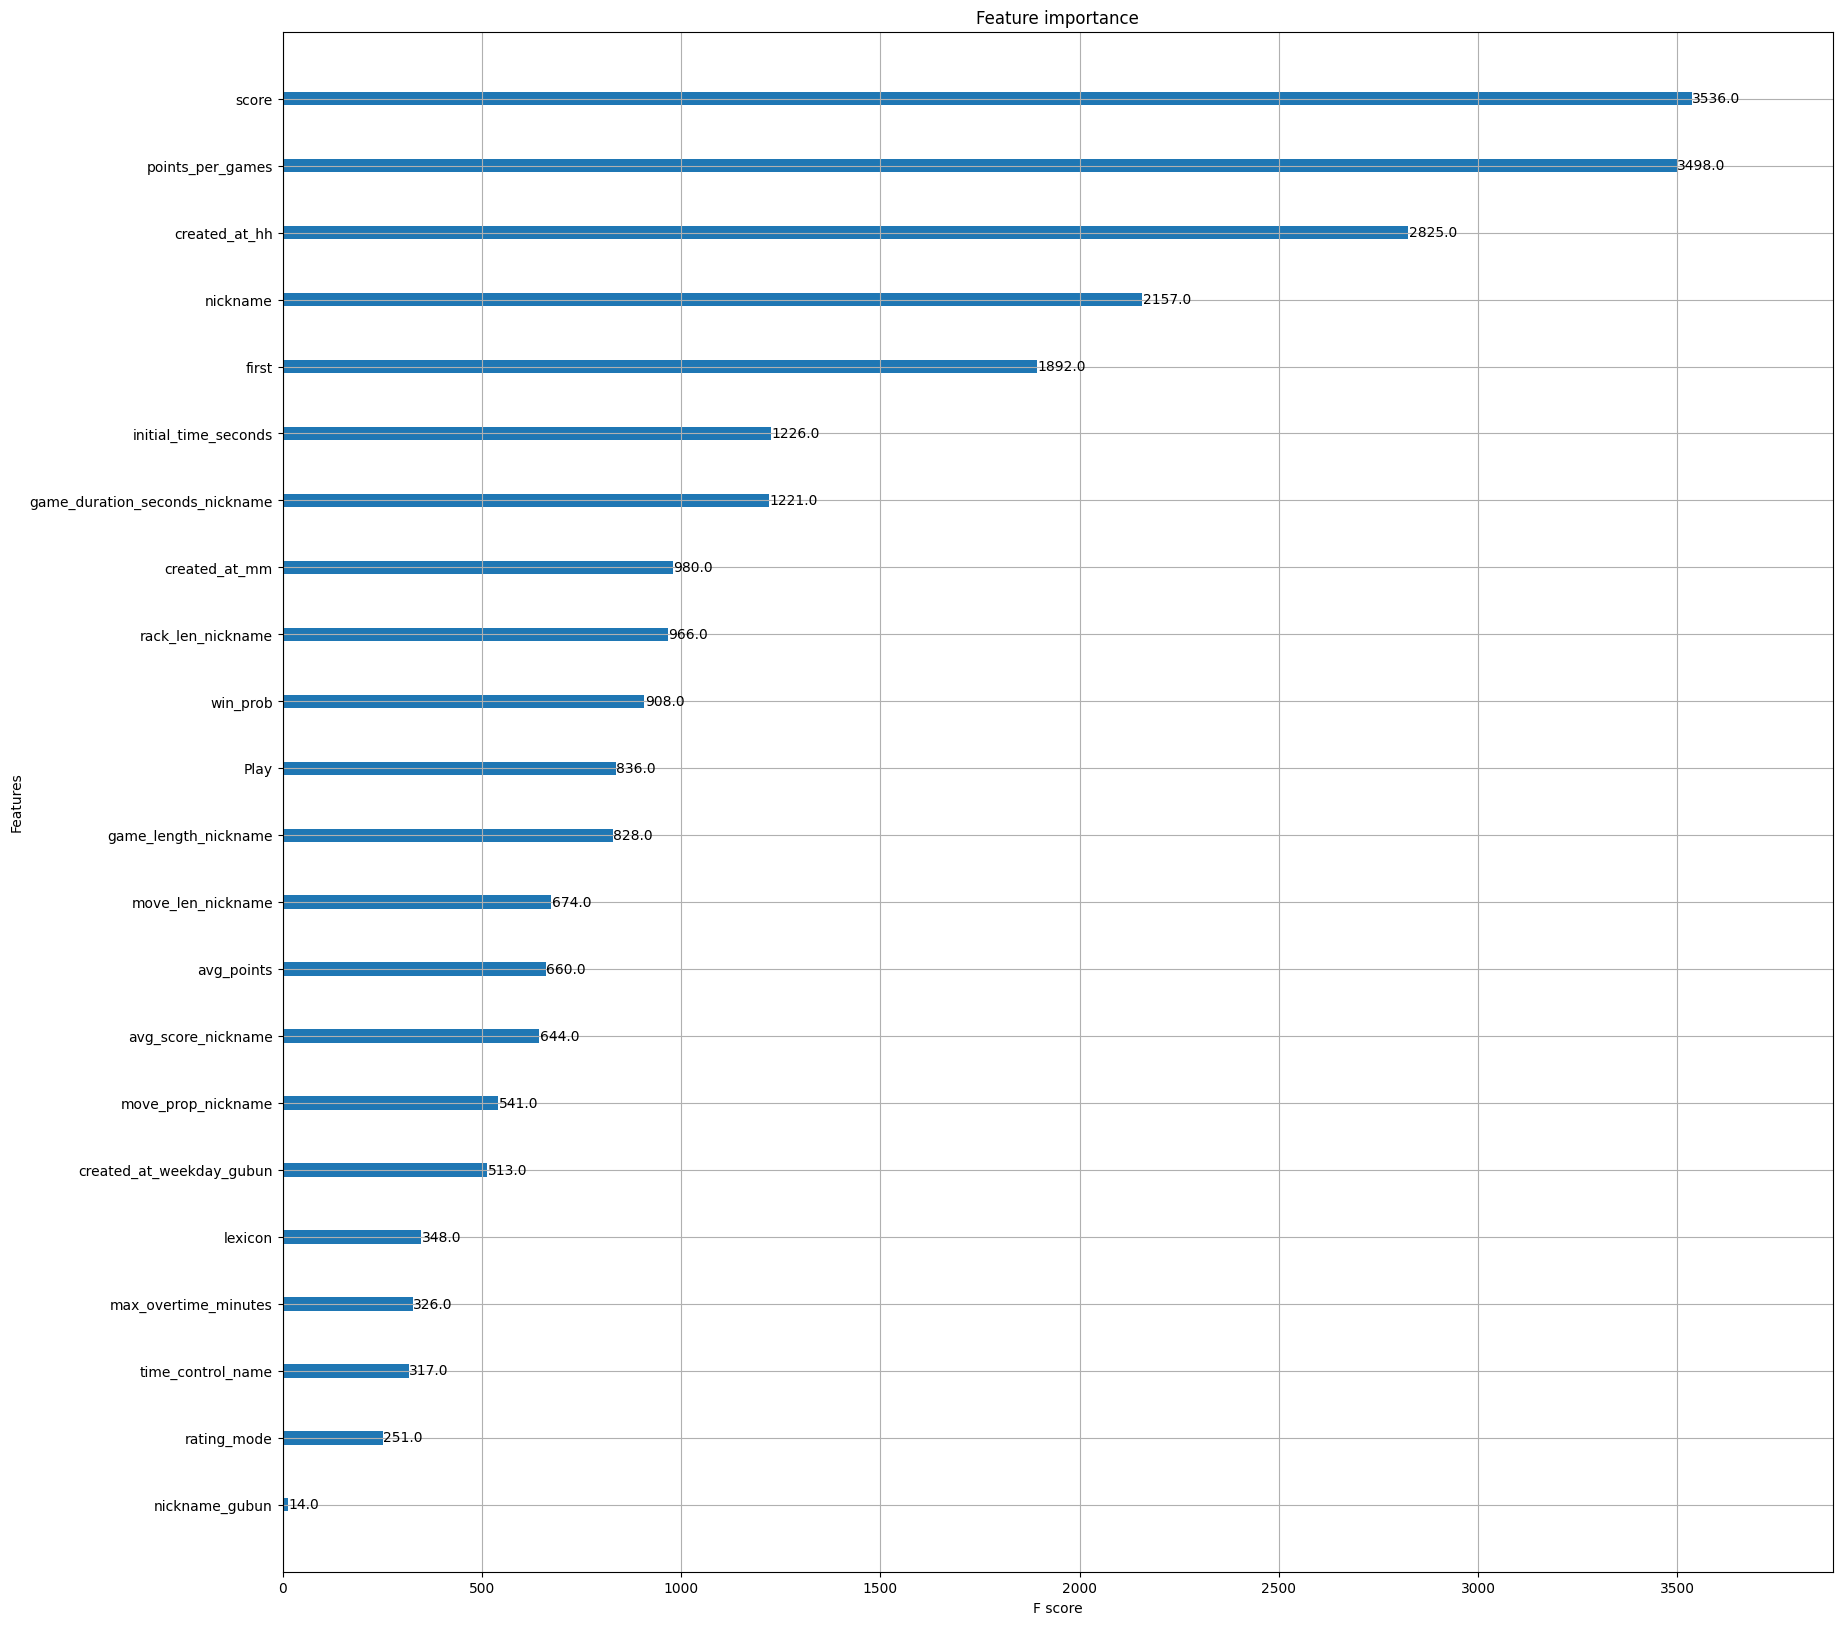

In [172]:
# 변수 선택
col_nm = ['nickname','score','first','time_control_name','lexicon','initial_time_seconds',
          'game_duration_seconds_nickname','created_at_mm','created_at_hh',
          'game_length_nickname','points_per_games','avg_points','rack_len_nickname','move_len_nickname','move_prop_nickname','rating_mode',
          'max_overtime_minutes','Play','win_prob','avg_score_nickname','nickname_gubun','created_at_weekday_gubun']

# label encoding
str_col = ['nickname','first','time_control_name','lexicon','rating_mode']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
#     for label in np.unique(test[i]):
    for label in (test[i].unique()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

x_train, x_valid, y_train, y_valid = train_test_split(train[col_nm], train['rating'], test_size=0.2, shuffle=True, random_state=34)
# print(x_train.shape,y_train.shape)

model = XGBRegressor(n_estimators=500)
model.fit(x_train,y_train) 

from sklearn.metrics import accuracy_score

y_pred = model.predict(x_valid) # 예측 라벨(0과 1로 예측)

# 예측 라벨과 실제 라벨 사이의 정확도 측정
print('R2:', model.score(x_valid, y_valid)) 
print('rmse:',mean_squared_error(y_valid, y_pred, squared=False))
print('mape:', np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100)

preds = model.predict(test[col_nm])

test['preds'] = preds
final_preds = test[test.rating.isna()][['game_id','preds']]
final_preds.rename(columns={'preds':'rating'},inplace=True)
final_preds.to_csv('submission.csv',index=False)
plt.rcParams["figure.figsize"] = (20,20)
plot_importance(model)


- model history

In [ ]:
# - test1 : 0.9557134800161213
# - test2 : 0.9554823871904214
# - test3 : 0.956086669379342
# - test4 : 0.9669882752105765
# - test5 : 0.9672406552658899
# - test6 : 0.9660263769954107, 1.5752926439978432
# - test7 : 0.9673238165953698, 1.5274784140655004
# - test8 : 0.9712834555482946, 1.4254943345791098
# - test9 : 0.9714398197496708, 1.422561024811761
# - test10 : 0.9749036379875222, 1.3174166206785765(test9가 점수 더 높음)
# - test11 : 0.9718550710392531, 39.08486725252938, 1.4016930681107471